In [1]:
import numpy as np
from collections import Counter
import json

from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.model_zoo import load_url

from torchvision.models.inception import Inception3
from warnings import warn

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Обучающие картинки уже закодированы 2048-размерным вектором

In [3]:
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [4]:
print(img_codes[0,:10], end='\n\n')
print("Каждая картинка имеет 5 описаний\n")
print('\n'.join(captions[0]))

[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

Каждая картинка имеет 5 описаний

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Сделаем каждое предложение списком слов и укажем на конец и начало предложений специальными метками

In [5]:
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

Закодируем все слова которые достаточно часто встречаются

In [6]:
word_counts = Counter()

for img_i in tqdm(range(len(captions))):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

Выкинем все слова которые встречаются меньше 5 раз

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

In [9]:
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len, sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
as_matrix(captions[13])

array([[  1, 213, 214, 215, 185,   6,  24, 216, 217, 169, 141,   2,   3],
       [  1, 217, 169,  63, 136, 214, 218,  10, 219,  12,   2,   3,   3],
       [  1,  24, 131, 217, 169,  13,  14, 214,  15, 220,  12,   2,   3],
       [  1,  24, 169,  58, 112, 214, 123, 221,  15, 222, 223,  12,   2],
       [  1, 214,  15, 109, 224,  99, 107,  24, 217, 169,  12,   2,   3]],
      dtype=int32)

In [11]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        

        self.emb = nn.Embedding(n_tokens, emb_size)

        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        captions_emb = self.emb(captions_ix)

        
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
    
        answer = self.logits(lstm_out)
        
        return answer

In [12]:
network = CaptionNet(n_tokens)

In [13]:
network.load_state_dict(torch.load('./saved_network001.pth'))

In [14]:
class BeheadedInception3(Inception3):
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        x = F.avg_pool2d(x, kernel_size=8)
        x_for_capt = x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x_for_attn, x_for_capt, x
    

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [15]:
inception = beheaded_inception_v3().train(False)

In [16]:
def generate_caption(image, caption_prefix = ("START",), t=1, sample=True, max_len=100):
    
    image = torch.FloatTensor(image.transpose([2, 0, 1]))
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.LongTensor(prefix_ix)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.numpy()
        
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [17]:
img = plt.imread('data/img1.jpg')

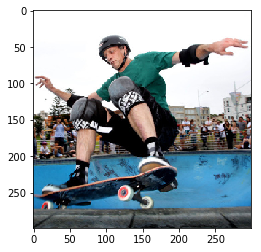

a boy is jumping in the air with his skateboard .
a man is jumping on his skate board
a man on a skateboard in a skate park .
a skateboarder is doing a trick on a skateboard .
a guy doing a trick on a skateboard ramp .
a man is riding a skateboard down a ramp .
a skateboarder is doing tricks in the air .
a man on a skateboard and a trick on a skateboard .
a skateboarder is jumping over his skateboard .
a skateboarder in the air with a skateboard .


In [18]:
img = plt.imread('data/img1.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img)/255.0
plt.imshow(img)
plt.show()
for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

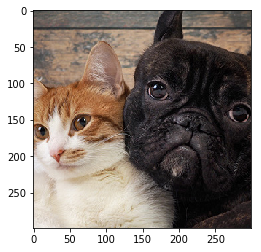

a cat is laying on a couch looking into the camera
a cat is lying on a bed and a cat looking out of a window .
a cat laying on a bed next to a pair of shoes .
a black cat laying on a couch with a cat in a suitcase .
a cat is laying on a pillow next to a car .
a cat watches a laptop on a desk .
a cat stares at a camera next to a car .
a black and white cat wearing a white hat and a striped hat on the ground .
a brown and white cat laying on a white teddy bear .
a cat lying on a car seat in a bathroom .


In [19]:
img = plt.imread('data/img2.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img)/255.0
plt.imshow(img)
plt.show()
for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

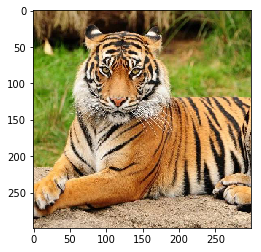

a close up of a bird on a small table .
a #UNK# of a black and white cat is on a bench .
a black and white bird standing on a branch
a close up of a bird on a tree branch
a bird is standing on a branch .
a bird is standing on a branch of a tree .
a large brown and white bird in a small room .
a black and black and white picture of a brown and white dog .
a couple of large brown bears are on a white surface .
a #UNK# of a white and black and white dog .


In [20]:
img = plt.imread('data/img3.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img)/255.0
plt.imshow(img)
plt.show()
for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

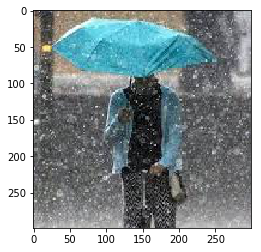

a man walking down a sidewalk holding an umbrella .
three people are walking with umbrellas in the rain .
a woman walking with a umbrella on her cell phone .
a woman sitting on a bench under umbrellas .
a woman holding an umbrella on a sandy beach .
a lady is holding a red umbrella in the rain .
a woman walking down a street with an umbrella .
a woman holds a picture of a child walking down the street .
a woman in a black #UNK# walking down a lamp with umbrellas .
a person with a red umbrella walking in a field .


In [21]:
img = plt.imread('data/img4.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img)/255.0
plt.imshow(img)
plt.show()
for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))